In [ ]:
%pip install numpy

In [ ]:
%pip install pandas

In [ ]:
%pip install networkx

In [ ]:
%pip install matplotlib

In [ ]:
%pip install tqdm

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from tqdm import tqdm
from networkx.drawing.nx_pydot import graphviz_layout
from collections import Counter

# Base para todos

## implementations

exponential mechanism

In [3]:
def exp_mechanism_k(utilites, list_outputs, epsilon, global_sensivity):
    probs = [np.exp(epsilon * utilites[out] / (2 * global_sensivity)) for out in list_outputs]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)

    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0], probs_normalizadas

local dampening mechanism

In [4]:
def dampening_function_k(data, output, score_val, delta_func, target = None):
    b_list = [0]
    i = 0  
    b_list.append(delta_func(data, i, output) if target == None else delta_func(data, i, output, target))
    
    while True:
        if (score_val >= 0 and (score_val < b_list[-2] or score_val >= b_list[-1])) or (score_val < 0 and (score_val < -b_list[-1] or score_val >= -b_list[-2])):
            i += 1
            d_func = delta_func(data, i, output) if target == None else delta_func(data, i, output, target)
            b_list[-2] = b_list[-1]
            b_list[-1] += d_func
            continue

        D_val = (score_val - b_list[-2]) / (b_list[-1] - b_list[-2]) + i if score_val > 0 else (score_val + b_list[-2]) / np.abs(-b_list[-1] + b_list[-2]) - i

        return D_val

def local_dampening_mechanism_k(data, utilites, delta_func, list_outputs, 
                                epsilon, target = None, shifted = False, global_sensivity = None):
    if shifted == True:
        max_utility = max(utilites.values())
        for k in utilites:
            utilites[k] -= (global_sensivity + max_utility)

    scores = np.array([dampening_function_k(data, out, utilites[out], delta_func, target) for out in list_outputs])
    n = len(scores)
    if scores.std() == 0:
        scores = [1/n for i in range(n)]
    else:
        if n > 1:
            scores = (scores - scores.mean()) / scores.std()
    probs = [np.exp(epsilon * score / 2) for score in scores]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)
    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]


def local_dampening_mechanism_k_v2(data, utilites, delta_func, list_outputs, 
                                epsilon, target = None, probs = None):
    if probs is not None:
        return np.random.choice(list_outputs, 1, p=probs)[0]

    scores = np.array([dampening_function_k(data, out, utilites[out], delta_func, target) for out in list_outputs])
    probs = np.array([np.exp(epsilon * score / 2) for score in scores])
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)

    data = [np.random.choice(list_outputs, 1, p=probs_normalizadas)[0], probs_normalizadas]
    
    return data

permute and flip mechanism

In [5]:
def permute_and_flip_k(utilities, epsilon, global_sensivity):
    max_score = max(utilities.values())
    chaves_embaralhadas = list(utilities.keys())
    np.random.shuffle(chaves_embaralhadas)

    for k in chaves_embaralhadas:
        prob = np.exp(epsilon * (utilities[k] - max_score) / (2 * global_sensivity))
        if np.random.rand() < prob:
            return k

# Algoritmo 7

Note que a um dict chamado "big" perdido ali no meio. Ele foi colocado para evitar cálculos desnecessários, tornando a tarefa mais rápida e, de fato, factível. Antes dele, demorava, em média, 30 minutos para construir uma arvore com base em um dataset grande.

In [6]:
def get_new_candidate(candidates, tau, atual):
    new_candidates = []
    for candidate in candidates[atual:]:
        if candidate[0] > 0 and candidate[1] > 0:
            new_candidates.append((candidate[0] - 1, candidate[1] - 1))
        if candidate[0]  < tau:
            new_candidates.append((candidate[0] + 1, candidate[1]))
    return new_candidates

def h_func(x, y):
    def f_func(x, somar = False):
        if (x <= 0 and somar) or (x <= 1 and not somar):
           return 0
        return x * np.log2((x + 1) / x) + np.log2(x + 1) if somar else x * np.log2((x - 1) / x) - np.log2(x - 1)
    return max(f_func(x, True) - f_func(y, True), f_func(x) - f_func(y))

big = {}

def local_sensivity_at_tDistance_alg7(data:pd.DataFrame, t:float, col_val, target):
    if not col_val in big:
        big[col_val] = {}
    
    if not t in big[col_val]:
        H = []
        if t == 0:
            candidatos = []
            for j_val in data[col_val].unique():
                recorte_Aj = data[data[col_val] == j_val]
                for c_val in recorte_Aj[target].unique():
                    recorte_Ajc = recorte_Aj[recorte_Aj[target] == c_val]
                    candidatos.append((len(recorte_Aj), len(recorte_Ajc)))
                    H.append(h_func(len(recorte_Aj), len(recorte_Ajc)))
            big[col_val][t] = max(H)
            big[col_val]["candidatos"] = candidatos
            big[col_val]["atual"] = 0
        else:
            new_candidates = get_new_candidate(big[col_val]["candidatos"], data.shape[0], big[col_val]["atual"])
            for x, y in new_candidates:
                H.append(h_func(x,y))
            big[col_val][t] = max(max(H), big[col_val][t - 1])
            big[col_val]["candidatos"] += new_candidates
            big[col_val]["atual"] += len(new_candidates)

    return big[col_val][t]

In [7]:
def noisy_count(data: pd.DataFrame, target, epsilon):
    exact_count = data[target].shape[0]
    noise = np.random.laplace(scale = 1 / epsilon)
    noisy_count = exact_count + np.abs(noise)

    return noisy_count

# Equação 7.2
def score_func_alg7(data: pd.DataFrame, r_col, target):
    infGain_list = []
    for j_val in data[r_col].unique():
        data_colR_valA = data[data[r_col] == j_val]
        tau_j = data_colR_valA.shape[0]
        for c_val in data_colR_valA[target].unique():

            data_colR_valA_outC = data_colR_valA[data_colR_valA[target] == c_val]
            tau_jc = data_colR_valA_outC.shape[0]
            # print(tau_j, tau_jc, j_val, c_val)
            infGain_list.append(tau_jc * np.log2(tau_jc / tau_j))
    
    return -sum(infGain_list)

def score_func_shifted_alg7(data, r_col, target):
    n = len(data)
    lista_colunas = data.columns.to_list()
    lista_colunas.remove(target)
    max_score = max(score_func_alg7(data, out, target) for out in lista_colunas)

    return score_func_alg7(data, r_col, target) - n * (np.log2(n + 1) + 1/np.log(2)) - max_score

def build_diff_PID3(data:pd.DataFrame, list_columns: list, target, 
                    profundidade, epsilon, typo, pai = None, global_sensivity = None):
    data_target_list = data[target].unique()

    if len(list_columns) == 0 or profundidade == 0:
        data_output_partitions = [noisy_count(data[data[target] == c], target, epsilon) for c in data_target_list]

        max_Nc = max(data_output_partitions)
        leaf = data_target_list[data_output_partitions.index(max_Nc)]
        name_node = f"{leaf}" 
        name_node = name_node + f":id:{pai}" if pai != None else name_node

        return name_node
    
    t_val = max([len(data[col].unique()) for col in list_columns])
    N_t = noisy_count(data, target, epsilon)

    if N_t / (t_val * len(data_target_list)) < np.sqrt(2)/2:
        data_output_partitions = [noisy_count(data[data[target] == c], target, epsilon) for c in data_target_list]
        max_Nc = max(data_output_partitions)
        leaf = data_target_list[data_output_partitions.index(max_Nc)]
        name_node = f"{leaf}" 
        name_node = name_node + f":id:{pai}" if pai != None else name_node
        
        return name_node
    
    utilites = {out: score_func_alg7(data, out, target) for out in list_columns}
    
    if typo == "exp":
        columns_hat, _ = exp_mechanism_k(utilites, list_columns, epsilon, global_sensivity)
    elif typo == "ld":
        columns_hat = local_dampening_mechanism_k(data, utilites, local_sensivity_at_tDistance_alg7, 
                                                  list_columns, epsilon, target, 
                                                  global_sensivity=global_sensivity)
    elif typo == "ls":
        columns_hat = local_dampening_mechanism_k(data, utilites, local_sensivity_at_tDistance_alg7, 
                                                  list_columns, epsilon, target, 
                                                  global_sensivity=global_sensivity, shifted=True)


    data_i = [(data[data[columns_hat] == i], i ) for i in data[columns_hat].unique()]
    lista_copiada = list_columns.copy()
    lista_copiada.remove(columns_hat)
    arvore = []

    for dado in data_i:
        node = build_diff_PID3(dado[0], lista_copiada, target, profundidade - 1, 
                               epsilon, typo, f"{columns_hat}{dado[1]}", 
                               global_sensivity = global_sensivity)

        arvore.append({
            "from": f"{columns_hat}",
            "to": node,
            "edge_name": dado[1]
        })
    
    return arvore

def global_diff_PID3(data:pd.DataFrame, target, profundidade: int, privacy_budget: float, typo: str, shifted = False):
    epsilon = privacy_budget / (2 * (profundidade + 1))
    lista_colunas = data.columns.to_list()
    lista_copiada = lista_colunas.copy()
    lista_copiada.remove(target)

    global_sensivity = np.log2(data.shape[0] + 1) + 1/np.log(2)
    arvore = build_diff_PID3(data, lista_copiada, target, profundidade, 
                             epsilon, typo, global_sensivity = global_sensivity)

    return arvore

def molde2draw(molde):
    G = nx.DiGraph()
    lista_labels = {}

    def add_edge(from_name, to_name, edge_label):
        if isinstance(to_name, list):
            for item in to_name:
                to_name = item["from"]
                add_edge(item["from"], item["to"], item["edge_name"])
            
        G.add_edge(from_name, to_name)
        lista_labels[(from_name, to_name)] = edge_label

    for dict_node in molde:
        add_edge(dict_node["from"], dict_node["to"], dict_node["edge_name"])

    root = molde[0]["from"]
    pos = nx.bfs_layout(G, root)
    nx.draw(
        G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color='pink', alpha=0.9,
        labels={node: node.split(":id:")[0] for node in G.nodes()}
    )
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=lista_labels,
        font_color='red'
    )
    plt.axis('off')
    plt.show()

In [8]:
dict_data = {
    "Outlook": ["rain", "rain", "sun", "sun", "sun"],
    "Wind": ["strong", "weak", "strong", "weak", "strong"],
    "Decision": ["y", "n", "y", "n", "n"]
}

data_example = pd.DataFrame(dict_data)
data_example

,Outlook,Wind,Decision
0,rain,strong,y
1,rain,weak,n
2,sun,strong,y
3,sun,weak,n
4,sun,strong,n


Nesse caso, se o epsilon for muito grande, o score cresce para infinito e se for muito pequeno retorna somente um nó (no mecanismo exponencial, o outro nem roda)

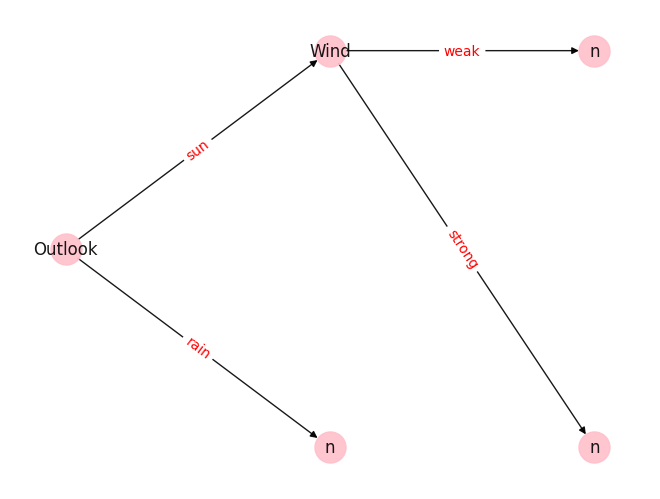

[{'from': 'Outlook', 'to': 'n:id:Outlookrain', 'edge_name': 'rain'}, {'from': 'Outlook', 'to': [{'from': 'Wind', 'to': 'n:id:Windstrong', 'edge_name': 'strong'}, {'from': 'Wind', 'to': 'n:id:Windweak', 'edge_name': 'weak'}], 'edge_name': 'sun'}]


In [8]:
epsilon = 10
arvore_molde_example = global_diff_PID3(data_example, "Decision", 2, epsilon, "exp")
molde2draw(arvore_molde_example)
print(arvore_molde_example)

In [9]:
car_data = pd.read_csv("./data/car_evalueate.csv")
car_data

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


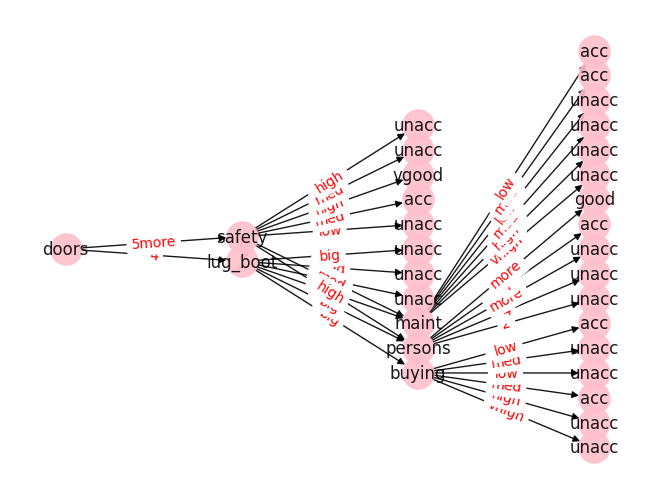

In [10]:
epsilon = 1
arvore_molde_car = global_diff_PID3(car_data, "class", 3, epsilon, "ld", shifted = True)
molde2draw(arvore_molde_car)

In [11]:
row = []
with open("./data/breast-cancer.data") as f:
    for r in f:
        row.append(r.split(","))

cancer_data = pd.DataFrame(row, columns = ["Class", "age", "menopause", "tumor-size", "inv-nodes", "nodes-caps", "deg-malig", "breast", "breast-quad", "irradiat"])
cancer_data = cancer_data.replace({"recurrence-events":"y", "no-recurrence-events":"n"})
cancer_data

,Class,age,menopause,tumor-size,inv-nodes,nodes-caps,deg-malig,breast,breast-quad,irradiat
0,n,30-39,premeno,30-34,0-2,no,3,left,left_low,no\n
1,n,40-49,premeno,20-24,0-2,no,2,right,right_up,no\n
2,n,40-49,premeno,20-24,0-2,no,2,left,left_low,no\n
3,n,60-69,ge40,15-19,0-2,no,2,right,left_up,no\n
4,n,40-49,premeno,0-4,0-2,no,2,right,right_low,no\n
...,...,...,...,...,...,...,...,...,...,...
281,y,30-39,premeno,30-34,0-2,no,2,left,left_up,no\n
282,y,30-39,premeno,20-24,0-2,no,3,left,left_up,yes\n
283,y,60-69,ge40,20-24,0-2,no,1,right,left_up,no\n
284,y,40-49,ge40,30-34,3-5,no,3,left,left_low,no\n


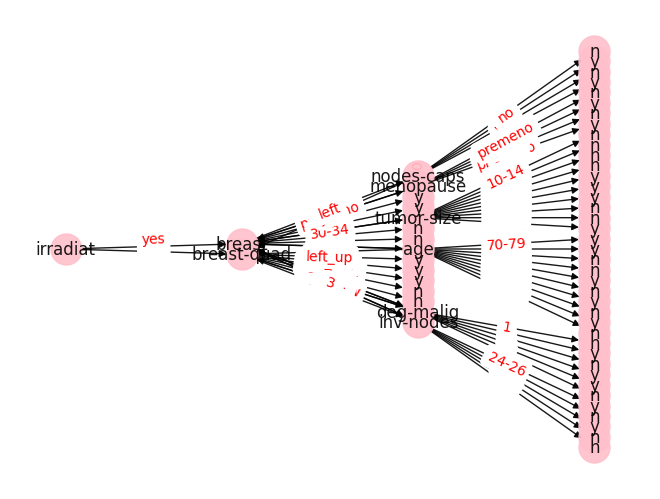

In [12]:
epsilon = 0.1
arvore_molde_cancer = global_diff_PID3(cancer_data, "Class", 5, epsilon, "ld")
molde2draw(arvore_molde_cancer)

In [13]:
cogumelos = pd.read_csv("./data/muschroom.csv")
cogumelos_cleaned = cogumelos.dropna(axis=1)
cogumelos_cleaned

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,o,o,p,o,o,p,b,c,l,e
8120,x,s,n,f,n,a,c,b,y,e,...,o,o,p,n,o,p,b,v,l,e
8121,f,s,n,f,n,a,c,b,n,e,...,o,o,p,o,o,p,b,c,l,e
8122,k,y,n,f,y,f,c,n,b,t,...,w,w,p,w,o,e,w,v,l,p


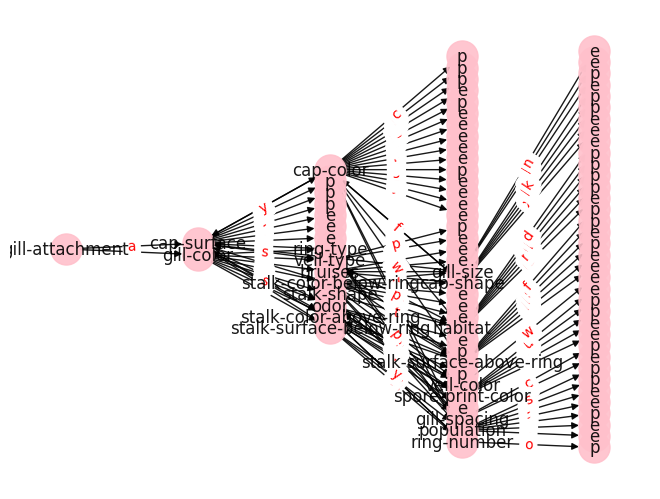

In [14]:
epsilon = 0.1
arvore_molde_mush = global_diff_PID3(cogumelos_cleaned, "poisonous", 5, epsilon, "ld")
molde2draw(arvore_molde_mush)

In [15]:
obesity = pd.read_csv("./data/obesidade.csv")
obesity
c_drop = []
for c in obesity.columns:
    if len(obesity[c].unique()) > 10:
        c_drop.append(c)

obesity_categorical = obesity.drop(columns=c_drop)
obesity_categorical

,Gender,CALC,FAVC,SCC,SMOKE,family_history_with_overweight,CAEC,MTRANS,NObeyesdad
0,Female,no,no,no,no,yes,Sometimes,Public_Transportation,Normal_Weight
1,Female,Sometimes,no,yes,yes,yes,Sometimes,Public_Transportation,Normal_Weight
2,Male,Frequently,no,no,no,yes,Sometimes,Public_Transportation,Normal_Weight
3,Male,Frequently,no,no,no,no,Sometimes,Walking,Overweight_Level_I
4,Male,Sometimes,no,no,no,no,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...
2106,Female,Sometimes,yes,no,no,yes,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,Sometimes,yes,no,no,yes,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,Sometimes,yes,no,no,yes,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,Sometimes,yes,no,no,yes,Sometimes,Public_Transportation,Obesity_Type_III


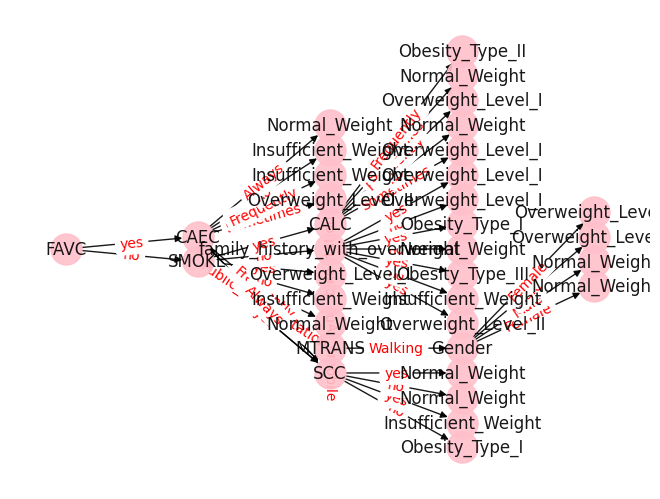

In [16]:
epsilon = 2
arvore_molde_obesity = global_diff_PID3(obesity_categorical, "NObeyesdad", 4, epsilon, "ld")
molde2draw(arvore_molde_obesity)

In [17]:
rows = []
with open("./data/nltcs.test.wdata") as f:
    for row in f:
        rows.append(row.split("|")[1].split(","))

with open("./data/nltcs.valid.wdata") as f:
    for row in f:
        rows.append(row.split("|")[1].split(","))

with open("./data/nltcs.train.wdata") as f:
    for row in f:
        rows.append(row.split('|')[1].split(","))

columns = [f"c{i+1}" for i in range(15)]
columns.append("target")
data_nltcs = pd.DataFrame(rows, columns=columns)
data_nltcs

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,target
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0\n
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1\n
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0\n
4,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4442,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0\n
4443,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0\n
4444,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1\n
4445,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1\n


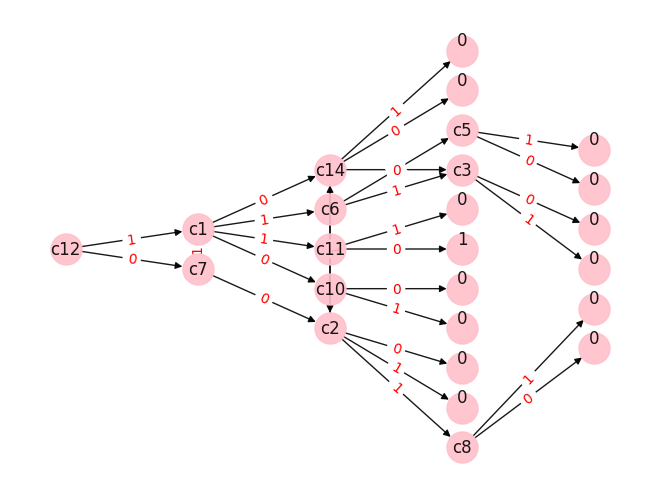

In [18]:
epsilon = 0.1
arvore_molde_obesity = global_diff_PID3(data_nltcs, "target", 4, epsilon, "ld")
molde2draw(arvore_molde_obesity)

In [19]:
data_adults = pd.read_csv("./data/adults.csv")
columns = []
for c in data_adults.columns:

    if len(data_adults[c].unique()) > 70:
        columns.append(c)

data_adults_categorical = data_adults.drop(columns = columns)
print("shape data: ", data_adults_categorical.shape)
data_adults_categorical_limpo = data_adults_categorical.dropna()
print("shape droping Nan", data_adults_categorical_limpo.shape)
cleaning = {
    '<=50K.':'<=50K',
    '>50K.':'>50K'
}
data_adults_categorical_limpo = data_adults_categorical_limpo.replace(cleaning)
data_adults_categorical_limpo

shape data:  (48842, 10)
shape droping Nan (47621, 10)


,workclass,education,education-num,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...
48836,Private,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,United-States,<=50K
48837,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,United-States,<=50K
48839,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
48840,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,United-States,<=50K


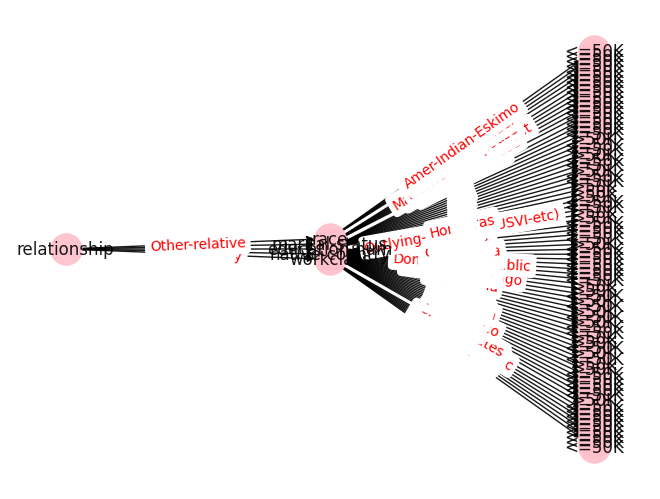

[{'from': 'relationship', 'to': [{'from': 'workclass', 'to': '<=50K:id:workclassState-gov', 'edge_name': 'State-gov'}, {'from': 'workclass', 'to': '<=50K:id:workclassPrivate', 'edge_name': 'Private'}, {'from': 'workclass', 'to': '<=50K:id:workclassLocal-gov', 'edge_name': 'Local-gov'}, {'from': 'workclass', 'to': '<=50K:id:workclassFederal-gov', 'edge_name': 'Federal-gov'}, {'from': 'workclass', 'to': '<=50K:id:workclassSelf-emp-inc', 'edge_name': 'Self-emp-inc'}, {'from': 'workclass', 'to': '<=50K:id:workclass?', 'edge_name': '?'}, {'from': 'workclass', 'to': '<=50K:id:workclassSelf-emp-not-inc', 'edge_name': 'Self-emp-not-inc'}, {'from': 'workclass', 'to': '<=50K:id:workclassNever-worked', 'edge_name': 'Never-worked'}], 'edge_name': 'Not-in-family'}, {'from': 'relationship', 'to': [{'from': 'native-country', 'to': '<=50K:id:native-countryUnited-States', 'edge_name': 'United-States'}, {'from': 'native-country', 'to': '>50K:id:native-countryIndia', 'edge_name': 'India'}, {'from': 'nati

In [20]:
epsilon = 1

arvore_molde_adults = global_diff_PID3(data_adults_categorical_limpo, "income", 2, epsilon, "ld")
molde2draw(arvore_molde_adults)
print(arvore_molde_adults)

In [28]:
def get_tree_dict(molde):
    my_dict = {}
    def pp(molde, depth = 0):
        if isinstance(molde["to"], list):
            for item in molde["to"]:
                pp(item, depth + 1)
            my_dict[(molde["from"], molde["edge_name"], depth)] = molde["to"][0]["from"]
        else:
            my_dict[(molde["from"], molde["edge_name"], depth)] = molde["to"]

    for it in molde:
        pp(it)
    
    my_dict = sorted(my_dict.items(), key=lambda item: item[0][2])
    return [(x[0], x[1].split(":id:")[0]) for x in my_dict]

def predictions(df, tree, targets, target):
    def get_classifications(teste):
        stack = [(teste, [])]  # Pilha de tuplas (teste, caminho)
        classifications = []

        while stack:
            current_teste, path = stack.pop()

            if current_teste[1] in targets:
                # Se o teste leva diretamente a um alvo, adiciona à lista de classificações
                classifications.append((current_teste[0][0], current_teste[0][1], current_teste[1]))
            else:
                # Procura por condições correspondentes na árvore
                matched_branches = [branch for branch in tree if branch[0][0] == current_teste[1]]

                if matched_branches:
                    for branch in matched_branches:
                        new_path = path + [(current_teste[0][0], current_teste[0][1])] + [branch]
                        stack.append((branch, new_path))

        return classifications

    ordem_profundidade = [get_classifications(row) for row in tree]
    certas = 0
    predicted_count = 0

    classificador = []
    for k in ordem_profundidade:
        if isinstance(k[0], list):
            for tup in k:
                classificador.append(tup)
        else:
            classificador.append(k)

    for ord in classificador:
        recorte = df
        for tup in ord:
            recorte = recorte[recorte[tup[0]] == tup[1]]
            if len(tup) == 2:
                continue
            predicted_count += len(recorte)
            recorte = recorte[recorte[target] == tup[2]]
            certas += len(recorte)
            if predicted_count == len(df):
                return 1, certas / predicted_count

    return 1, certas / predicted_count

## AVALIANDO ALGORITMO 7

In [33]:
def predict_labels(df, tree, targets, target):
    def traverse_tree(row, tree):
        current_node = tree[0][0][0]
        next_node = None
        for node in tree:
            (node_col, node_val, depth), next_col = node
            if node_col == current_node and row[node_col] == node_val:
                if next_col in targets:
                    return next_col
                else:
                    current_node = next_col
        return None

    predicted_labels = []
    certas = 0
    for _, row in df.iterrows():
        prediction = traverse_tree(row, tree)
        if row[target] == prediction:
            certas += 1
        predicted_labels.append(prediction)
    
    return predicted_labels, certas / len(df)

def cross_validation(data, depth, epsilon, target, n_folds=5):
    shuffled_indices = np.random.permutation(len(data))
    data = data.iloc[shuffled_indices].reset_index(drop=True)

    fold_size = len(data) // n_folds
    accuracies_exp = []
    accuracies_ldm = []
    accuracies_lsm = []

    for fold in range(n_folds):
        test_start = fold * fold_size
        test_end = test_start + fold_size
        if fold == n_folds - 1:
            test_end = len(data)
        
        data_test = data.iloc[test_start:test_end]
        data_train = pd.concat([data.iloc[:test_start], data.iloc[test_end:]], axis=0)

        # Fazer previsões
        arvore_molde_exp = global_diff_PID3(data_test, target, depth, epsilon, "exp")
        arvore_molde_ldm = global_diff_PID3(data_test, target, depth, epsilon, "ld")
        arvore_molde_lsm = global_diff_PID3(data_test, target, depth, epsilon, "ls")

        dict_tree_exp = get_tree_dict(arvore_molde_exp)
        _, accuracy_exp = predict_labels(data_train, dict_tree_exp, data_train[target].unique(), target)
        accuracies_exp.append(accuracy_exp)

        dict_tree_ldm = get_tree_dict(arvore_molde_ldm)
        _, accuracy_ldm = predict_labels(data_train, dict_tree_ldm, data_train[target].unique(), target)
        accuracies_ldm.append(accuracy_ldm)

        dict_tree_lsm = get_tree_dict(arvore_molde_lsm)
        _, accuracy_exp_lsm = predict_labels(data_train, dict_tree_lsm, data_train[target].unique(), target)
        accuracies_lsm.append(accuracy_exp_lsm)

    # Retornar a acurácia média
    mean_accuracy_exp = sum(accuracies_exp) / len(accuracies_exp)
    mean_accuracy_ldm = sum(accuracies_ldm) / len(accuracies_ldm)
    mean_accuracy_lsm = sum(accuracies_lsm) / len(accuracies_lsm)
    return mean_accuracy_exp, mean_accuracy_ldm, mean_accuracy_lsm

def make_test(data, target, epsilons, depths, name_dataset, n_folds = 10, n_amostras = 10):
    results = {}
    for depth in depths:
        mean_accuracy_exp_byE = []
        mean_accuracy_ldm_byE = []
        mean_accuracy_lsm_byE = []

        for epsilon in epsilons:
            cross_val = [cross_validation(data, depth, epsilon, target, n_folds = n_folds) for k in range(n_amostras)]
            r_exp = []
            r_ldm = []
            r_lsm = []
            for accuracies in cross_val:
                r_exp.append(accuracies[0])
                r_ldm.append(accuracies[1])
                r_lsm.append(accuracies[2])
            
            m_exp = np.mean(r_exp)
            m_ldm = np.mean(r_ldm)
            m_lsm = np.mean(r_lsm)
            mean_accuracy_exp_byE.append(m_exp)
            mean_accuracy_ldm_byE.append(m_ldm)
            mean_accuracy_lsm_byE.append(m_lsm)
            results[(depth, epsilon, "exp")] = m_exp
            results[(depth, epsilon, "ldm")] = m_ldm
            results[(depth, epsilon, "lsm")] = m_lsm

            print(f"Done epsilon {epsilon}")

        print(f"Done profundidade {depth}")
        x = np.arange(len(epsilons))
        plt.plot(x, mean_accuracy_exp_byE, color = "blue", marker = "o", markerfacecolor='none', label = "GlobalDiffPID3")
        plt.plot(x, mean_accuracy_ldm_byE, color = "red", marker = "s", markerfacecolor='none', label = "LocalDiffPID3")
        plt.plot(x, mean_accuracy_lsm_byE, color = "black", marker = "^", markerfacecolor='none', label = "ShiftedLocalDiffPID3")
        plt.title(f"Dataset {name_dataset} at {depth} - {n_amostras} amostras {n_folds}-cross validation")
        plt.ylabel("Accuracy média")
        plt.xticks(x, epsilons)
        plt.xlabel("Epsilons")
        plt.legend()
        plt.grid(True)
        plt.savefig(f'./plots/{name_dataset}_dp{depth}_{n_amostras}am_{n_folds}fd.svg')
        plt.show()
        print("-"*50)

    return results

Done epsilon 0.01
Done epsilon 0.05
Done epsilon 0.1
Done epsilon 0.5
Done epsilon 1.0
Done epsilon 2.0
Done profundidade 2


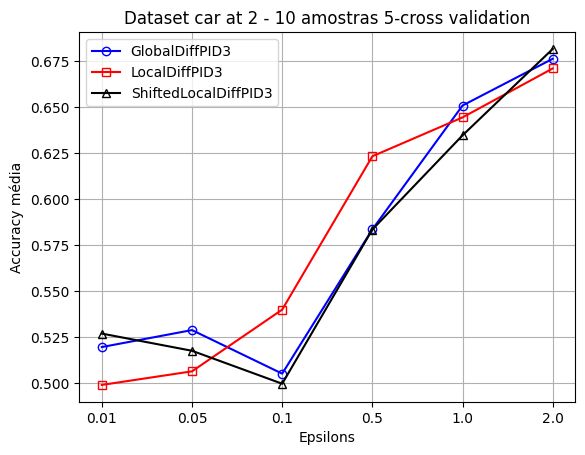

--------------------------------------------------
Done epsilon 0.01
Done epsilon 0.05
Done epsilon 0.1
Done epsilon 0.5
Done epsilon 1.0
Done epsilon 2.0
Done profundidade 5


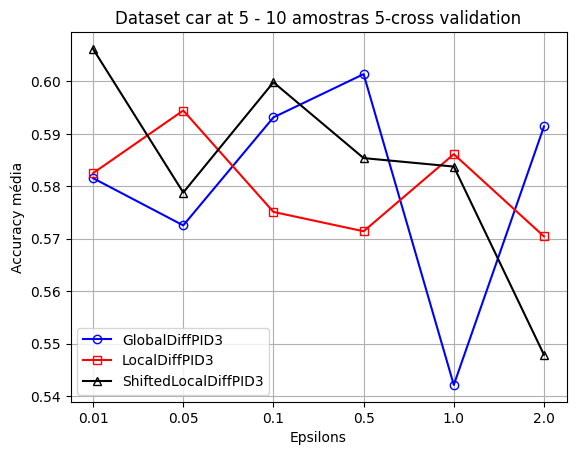

--------------------------------------------------


In [65]:
epsilons = [0.01, 0.05, 0.1, 0.5, 1., 2.]
depths = [2, 5]
results_car_ld = make_test(car_data, "class", epsilons, depths, name_dataset = "car", n_folds=5)

Done epsilon 0.01
Done epsilon 0.05
Done epsilon 0.1
Done epsilon 0.5
Done epsilon 1.0
Done epsilon 2.0
Done profundidade 2


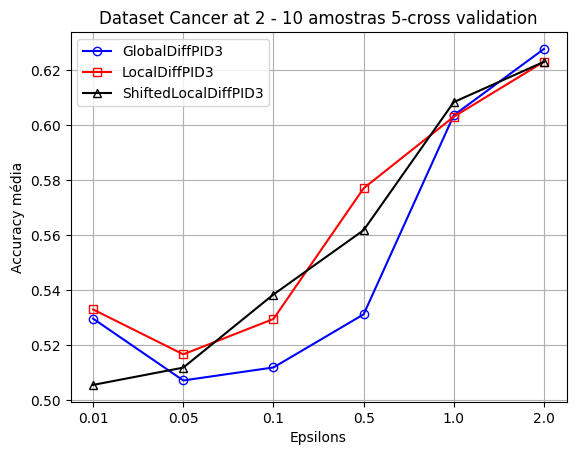

--------------------------------------------------
Done epsilon 0.01
Done epsilon 0.05
Done epsilon 0.1
Done epsilon 0.5
Done epsilon 1.0
Done epsilon 2.0
Done profundidade 4


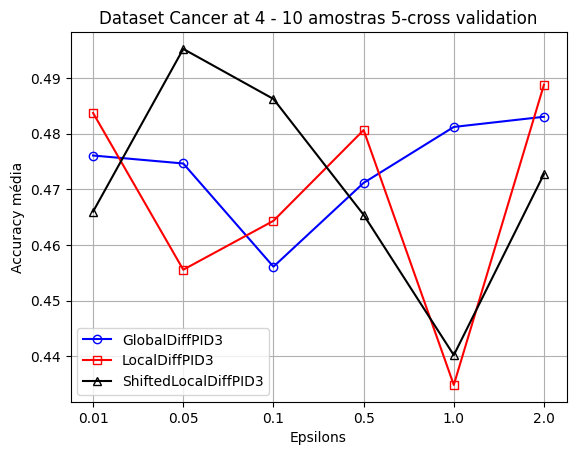

--------------------------------------------------


In [37]:
epsilons = [0.01, 0.05, 0.1, 0.5, 1., 2.]
depths = [2,5]
results_cancer = make_test(cancer_data, "Class", epsilons, depths, name_dataset = "Cancer", n_folds=5)

Done epsilon 0.01
Done epsilon 0.05
Done epsilon 0.1
Done epsilon 0.5
Done epsilon 1.0
Done epsilon 2.0
Done profundidade 2


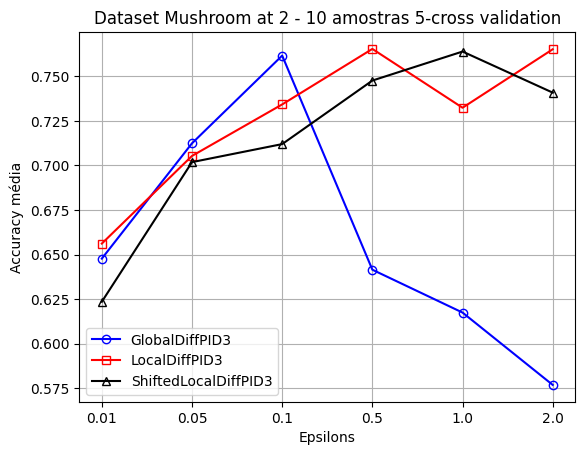

--------------------------------------------------


KeyboardInterrupt: 

In [66]:
epsilons = [0.01, 0.05, 0.1, 0.5, 1., 2.]
depths = [2,5]
results_cogumelos = make_test(cogumelos_cleaned, "poisonous", epsilons, depths, 
                              name_dataset = "Mushroom", n_folds=5)

ESSES É IMPORTANTE

Done epsilon 0.01
Done epsilon 0.05
Done epsilon 0.1
Done epsilon 0.5
Done epsilon 1.0
Done epsilon 2.0
Done profundidade 2


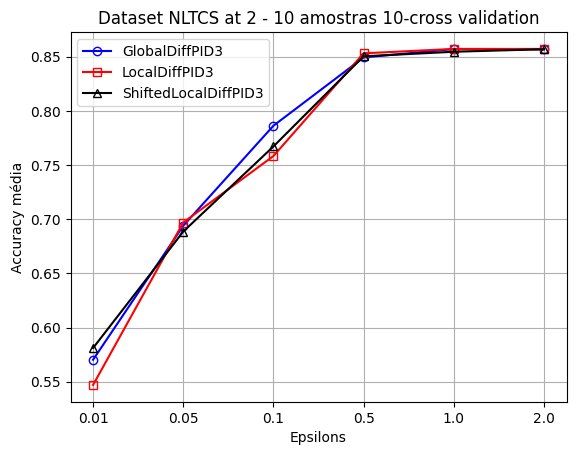

--------------------------------------------------
Done epsilon 0.01
Done epsilon 0.05
Done epsilon 0.1
Done epsilon 0.5
Done epsilon 1.0
Done epsilon 2.0
Done profundidade 5


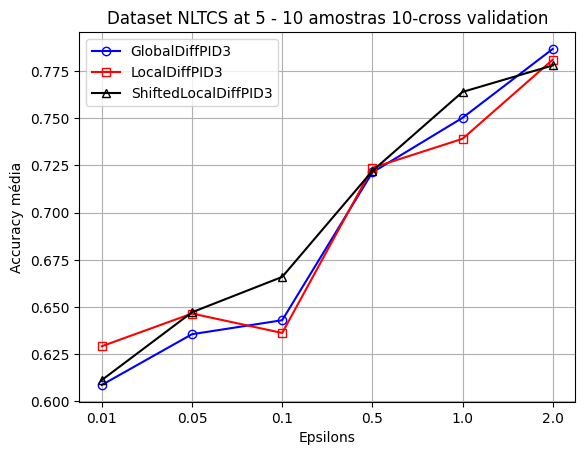

--------------------------------------------------


In [36]:
epsilons = [0.01, 0.05, 0.1, 0.5, 1., 2.]
depths = [2,5]
results_nltcs = make_test(data_nltcs, "target", epsilons, depths, name_dataset = "NLTCS",
                        n_folds=10, n_amostras=10)

In [ ]:
#INVIALVE

epsilons = [0.01, 0.05, 0.1, 0.5, 1., 2.]
depths = [2,5]
results_nltcs = make_test(data_adults_categorical_limpo, "income", epsilons, depths, 
                          name_dataset = "ADULTS", n_folds=10, n_amostras=10)

# Algoritmo 5

saida: o indíce do valor mais próximo da mediana

entrada: vetor x, com todos valores entre 0 e $\Lambda$

In [9]:
def local_sensivity_at_0_alg5(x:list, idx:int, param):
    # m = param[1]
    m = int(np.ceil(len(x)/2))
    def p(x, i):
        if i > m:
            return param[0] - x[i]
        if i == m:
            return param[0] - x[m + 1]
        return param[0] + x[i] - 3 * x[m] + x[m + 1]
    def q(x,i):
        if i > m:
            return x[i]
        if i == m:
            return x[m - 1]
        return 3 * x[m] - x[m - 1] - x[i]
    
    values = [np.abs(x[m] - x[idx]), x[m + 1] - x[m], x[m] - x[m - 1], p(x,idx), q(x,idx)]

    return max(values)

def copy_and_replace(x, idx = None, val = None):
    new_x = x.copy()
    if idx is None and val is None: return new_x
    new_x[idx] = val
    return np.sort(new_x)
    
def get_canditates_alg5(x, t, idx, param):
    if t == 0:
        return [x]
    m = int(np.ceil((len(x) + 1)/2))
    if t == 1:
        X = []
        X.append(copy_and_replace(x, idx, param[0]))
        X.append(copy_and_replace(x))
        X.append(copy_and_replace(x, idx, 0))
        X.append(copy_and_replace(x))
        X.append(copy_and_replace(x, m, param[0]))
        X.append(copy_and_replace(x, m, 0))
        return X
    X = get_canditates_alg5(x, t - 1, idx, param[0])
    return [copy_and_replace(i, m, param[0]) if m % 2 == 1 else copy_and_replace(i, m, 0) for i in X]

def local_sensivity_at_tDistance_alg5(x, t, i, param):
    list_candidates = get_canditates_alg5(x, t, i, param)
    return max([local_sensivity_at_0_alg5(candidate, i, param) for candidate in list_candidates])

def score_func_alg5(x, idx, param):
    m = param[1]
    return -np.abs(x[m] - x[idx])

## Avalaiando

In [10]:
def avaliation(x, score_func, epsilon_range, max_u = None, 
               n_amostras = 10000, delta_func = None, max_utility = None, name_fig = None):
    data_exp = []
    data_paf = []
    data_ldm = []
    list_outputs = [i for i in range(len(x))]
    utilites = {out: score_func(x, out, max_u) for out in list_outputs}
    max_utility = max(list(utilites.values()))

    uMax = max(x)

    for epsilon in tqdm(epsilon_range, desc="Processando epsilons", unit=" valor"):
        probs = [None, None, None]
        exp_results_byE = []
        ldm_results_byE = []
        paf_results_byE = [permute_and_flip_k(utilites, epsilon, uMax) for i in range(n_amostras)]

        for i in range(n_amostras):
            if i == 0:
                result_exp = exp_mechanism_k(utilites, list_outputs, epsilon, uMax)
                probs[0] = result_exp[1]
                exp_results_byE.append(result_exp[0])

                result_ldm = local_dampening_mechanism_k_v2(x, utilites, delta_func, list_outputs, epsilon, max_u)
                probs[1] = result_ldm[1]
                ldm_results_byE.append(result_ldm[0])

            else:
                exp_results_byE.append(np.random.choice(list_outputs, 1, p=probs[0])[0])
                ldm_results_byE.append(np.random.choice(list_outputs, 1, p=probs[1])[0])

        data_exp.append(np.mean([max_utility - utilites[i] for i in exp_results_byE]))
        data_paf.append(np.mean([max_utility - utilites[i] for i in paf_results_byE]))
        data_ldm.append(np.mean([max_utility - utilites[i] for i in ldm_results_byE]))

    if len(data_paf) > 0:
        plt.plot(epsilon_range, data_paf, linestyle = "--",color = "blue", label = "PFPercentileSelection")
    if len(data_exp) > 0:
        plt.plot(epsilon_range, data_exp, linestyle = "-",color = "black", label = "EMPercentileSelection")
    if len(data_ldm) > 0:
        plt.plot(epsilon_range, data_ldm, linestyle = ":",color = "red", label = "LDPercentileSelection")
    
    plt.legend()
    plt.title(f"Plot {n_amostras} amostras")
    plt.xlabel("Epsilon")
    plt.ylabel("Erro médio")
    plt.xscale('log')
    plt.grid(True)
    plt.savefig(f"./plots/{name_fig}_{n_amostras}_.svg")
    plt.show()

    return data_exp, data_paf, data_ldm

In [11]:
epsilons = np.logspace(-1, 2, 10)
n_amostras = 10000

## TESTE 1

In [12]:
n_array = 10000
lam = 10**5

Processando epsilons: 100%|██████████| 10/10 [04:07<00:00, 24.75s/ valor]


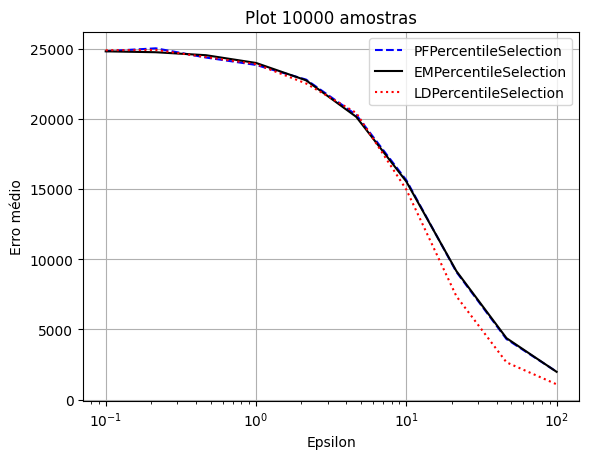

In [13]:
array_aleatorio = np.sort(np.random.rand(n_array) * lam)
percent = 50
percentile = int(np.ceil(percent / 100 * (n_array)))
parameters = [lam, percentile]
evalueate_1 = avaliation(array_aleatorio, 
                           score_func_alg5, 
                           epsilons, 
                           max_u = parameters,
                           n_amostras=n_amostras,
                           delta_func=local_sensivity_at_tDistance_alg5,
                           name_fig=f"max_{lam}_{percent}p_p1")

Processando epsilons:   0%|          | 0/10 [00:00<?, ? valor/s]

Processando epsilons: 100%|██████████| 10/10 [04:04<00:00, 24.42s/ valor]


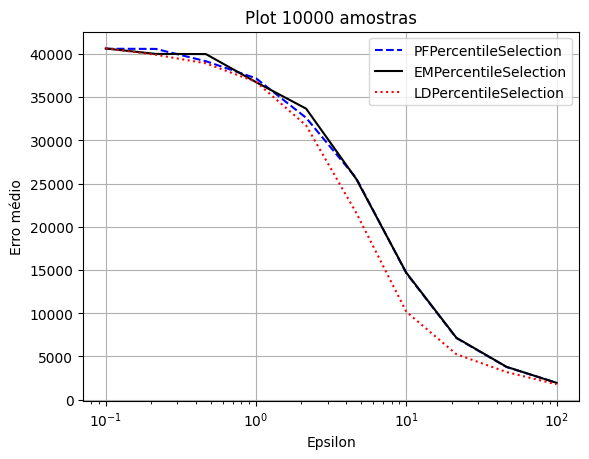

In [14]:
percent = 90
array_aleatorio = np.sort(np.random.rand(n_array) * lam)
percentile = int(np.ceil(percent / 100 * (n_array)))
parameters = [lam, percentile]
evalueate_1 = avaliation(array_aleatorio, 
                           score_func_alg5, 
                           epsilons, 
                           max_u = parameters,
                           n_amostras=n_amostras,
                           delta_func=local_sensivity_at_tDistance_alg5,
                           name_fig=f"max_{lam}_{percent}p_p1")

Processando epsilons:   0%|          | 0/10 [00:00<?, ? valor/s]

Processando epsilons: 100%|██████████| 10/10 [04:06<00:00, 24.67s/ valor]


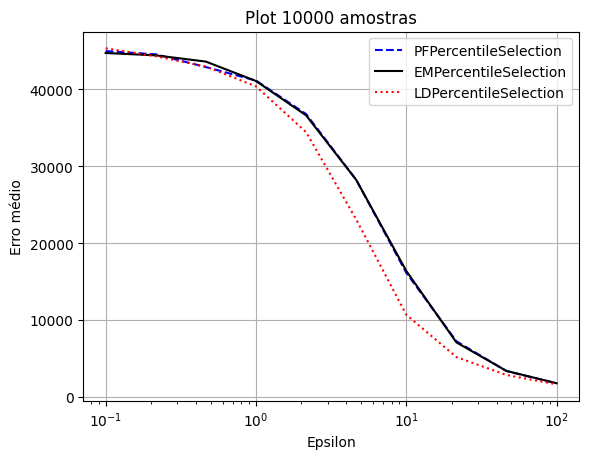

In [15]:
percent = 95
array_aleatorio = np.sort(np.random.rand(n_array) * lam)
percentile = int(np.ceil(percent / 100 * (n_array)))
parameters = [lam, percentile]
evalueate_1 = avaliation(array_aleatorio, 
                           score_func_alg5, 
                           epsilons, 
                           max_u = parameters,
                           n_amostras=n_amostras,
                           delta_func=local_sensivity_at_tDistance_alg5,
                           name_fig=f"max_{lam}_{percent}p_p1")

## TESTE 2

In [19]:
n_array = 10000
lam = 10**4
array_aleatorio = np.sort(np.random.rand(n_array) * lam)

Processando epsilons:   0%|          | 0/10 [00:00<?, ? valor/s]

Processando epsilons: 100%|██████████| 10/10 [03:59<00:00, 23.98s/ valor]


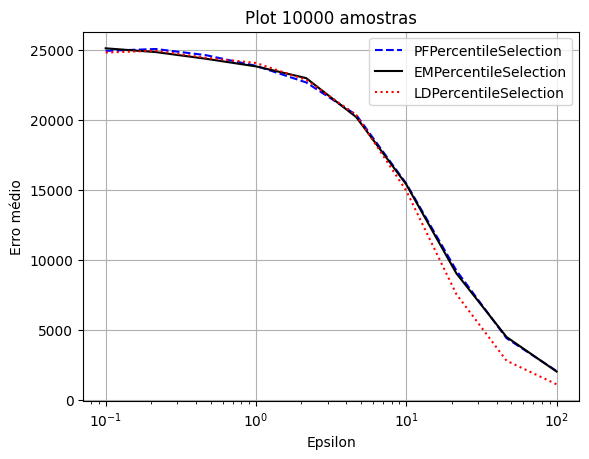

In [16]:
percent = 50
array_aleatorio = np.sort(np.random.rand(n_array) * lam)
percentile = int(np.ceil(percent / 100 * (n_array)))
parameters = [lam, percentile]
evalueate_1 = avaliation(array_aleatorio, 
                           score_func_alg5, 
                           epsilons, 
                           max_u = parameters,
                           n_amostras=n_amostras,
                           delta_func=local_sensivity_at_tDistance_alg5,
                           name_fig=f"max_{lam}_{percent}p_p2")

Processando epsilons:   0%|          | 0/10 [00:00<?, ? valor/s]

Processando epsilons: 100%|██████████| 10/10 [03:52<00:00, 23.20s/ valor]


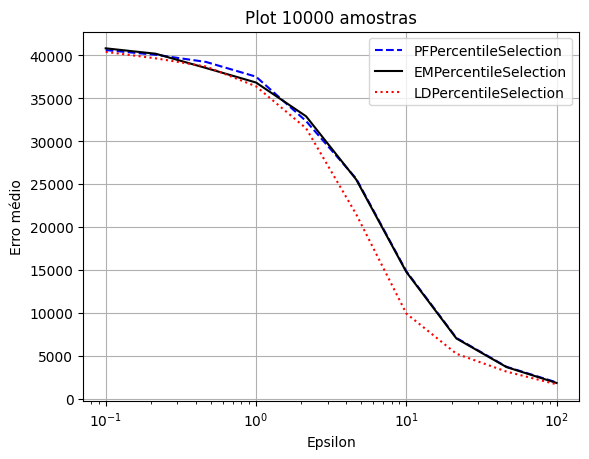

In [17]:
percent = 90
array_aleatorio = np.sort(np.random.rand(n_array) * lam)
percentile = int(np.ceil(percent / 100 * (n_array)))
parameters = [lam, percentile]
evalueate_1 = avaliation(array_aleatorio, 
                           score_func_alg5, 
                           epsilons, 
                           max_u = parameters,
                           n_amostras=n_amostras,
                           delta_func=local_sensivity_at_tDistance_alg5,
                           name_fig=f"max_{lam}_{percent}p_p2")

Processando epsilons:   0%|          | 0/10 [00:00<?, ? valor/s]

Processando epsilons: 100%|██████████| 10/10 [04:00<00:00, 24.03s/ valor]


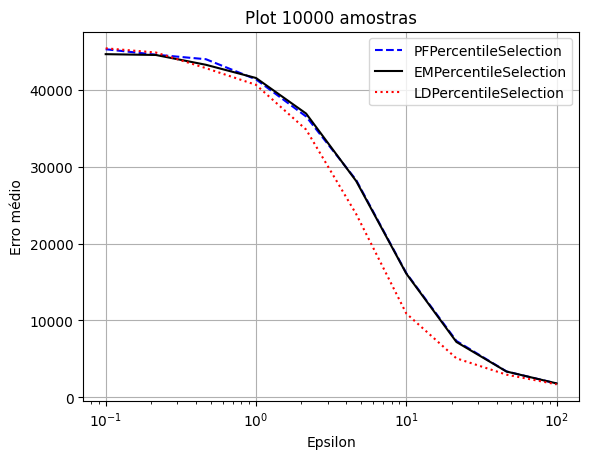

In [18]:
percent = 95
array_aleatorio = np.sort(np.random.rand(n_array) * lam)
percentile = int(np.ceil(percent / 100 * (n_array)))
parameters = [lam, percentile]
evalueate_1 = avaliation(array_aleatorio, 
                           score_func_alg5, 
                           epsilons, 
                           max_u = parameters,
                           n_amostras=n_amostras,
                           delta_func=local_sensivity_at_tDistance_alg5,
                           name_fig=f"max_{lam}_{percent}p_p2")

## TESTE 3

In [13]:
n_array = 1000
lam = 10**3
array_aleatorio = np.sort(np.random.rand(n_array) * lam)

Processando epsilons:   0%|          | 0/10 [00:00<?, ? valor/s]

Processando epsilons: 100%|██████████| 10/10 [00:35<00:00,  3.53s/ valor]


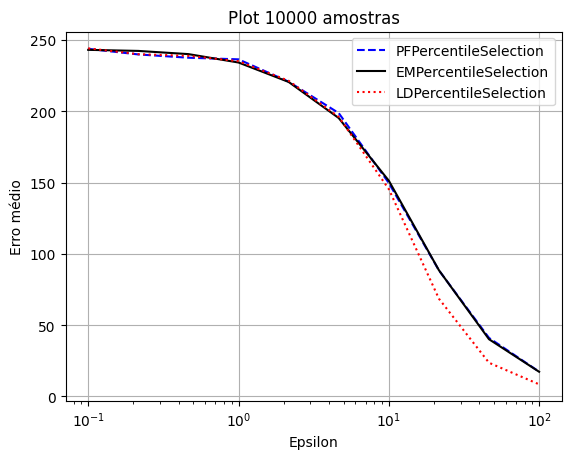

In [14]:
percent = 50
array_aleatorio = np.sort(np.random.rand(n_array) * lam)
percentile = int(np.ceil(percent / 100 * (n_array)))
parameters = [lam, percentile]
evalueate_1 = avaliation(array_aleatorio, 
                           score_func_alg5, 
                           epsilons, 
                           max_u = parameters,
                           n_amostras=n_amostras,
                           delta_func=local_sensivity_at_tDistance_alg5,
                           name_fig=f"REALLLLL")

Processando epsilons: 100%|██████████| 10/10 [00:33<00:00,  3.33s/ valor]


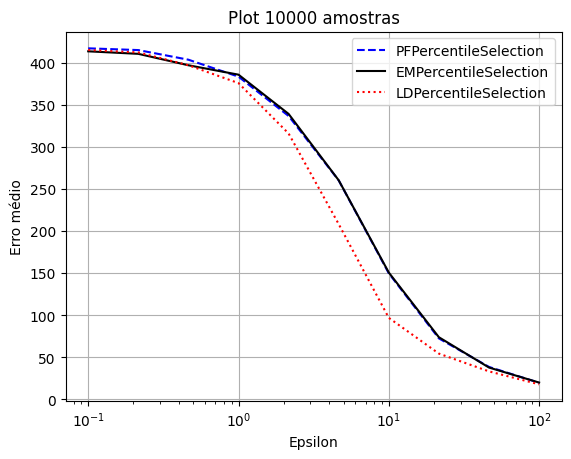

In [61]:
percent = 90
percentile = int(np.ceil(percent / 100 * (n_array)))
parameters = [lam, percentile]
evalueate_1 = avaliation(array_aleatorio, 
                           score_func_alg5, 
                           epsilons, 
                           max_u = parameters,
                           n_amostras=n_amostras,
                           delta_func=local_sensivity_at_tDistance_alg5,
                           name_fig=f"max_{lam}_{percent}p_p3")

Processando epsilons:   0%|          | 0/10 [00:00<?, ? valor/s]

Processando epsilons: 100%|██████████| 10/10 [04:03<00:00, 24.32s/ valor]


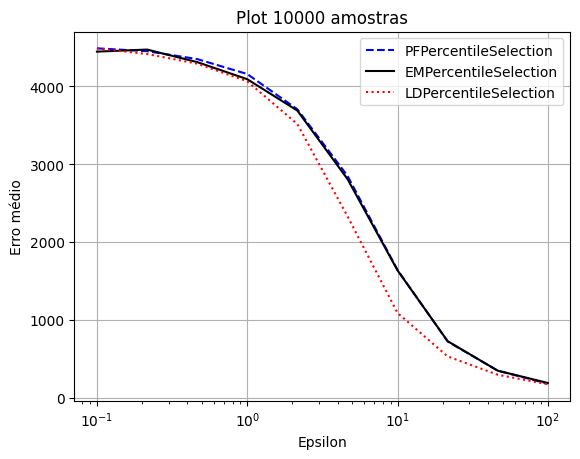

In [21]:
percent = 95
array_aleatorio = np.sort(np.random.rand(n_array) * lam)
percentile = int(np.ceil(percent / 100 * (n_array)))
parameters = [lam, percentile]
evalueate_1 = avaliation(array_aleatorio, 
                           score_func_alg5, 
                           epsilons, 
                           max_u = parameters,
                           n_amostras=n_amostras,
                           delta_func=local_sensivity_at_tDistance_alg5,
                           name_fig=f"max_{lam}_{percent}p_p3")

Processando epsilons: 100%|██████████| 6/6 [00:06<00:00,  1.15s/ valor]


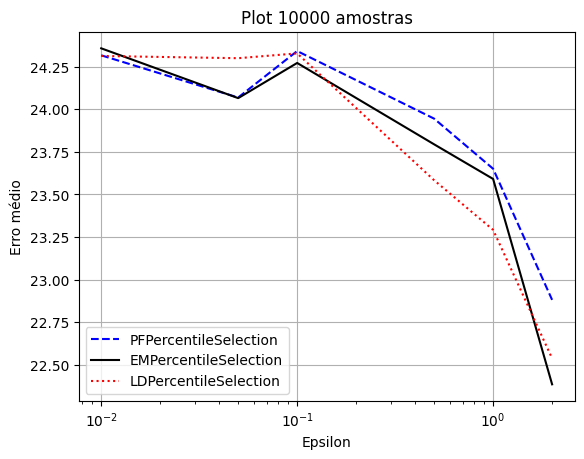

In [73]:
n_array = 100
lam = 10**2
array_aleatorio = np.sort(np.random.rand(n_array) * lam)
percent = 50
percentile = int(np.ceil(percent / 100 * (n_array)))
parameters = [lam, percentile]
evalueate_1 = avaliation(array_aleatorio, 
                           score_func_alg5, 
                           epsilons, 
                           max_u = parameters,
                           n_amostras=10000,
                           delta_func=local_sensivity_at_tDistance_alg5,
                           name_fig=f"max_{lam}_{percent}p_10")